<a href="https://colab.research.google.com/github/tozanni/bourbaki_deeplearning/blob/main/Intro_to_Pytorch_SLP_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introducción a Pytorch y MLP

## I. Perceptron simple



### 1. Definición del DataSet

Imagenes etiquetadas.

https://drive.google.com/drive/folders/1ZrLW2GqO107SggqDAbRn3ThVD95Hwlhr?usp=sharing


In [ ]:
import numpy as np 
import pandas as pd
import os
import torch
import torch.nn as nn

from skimage import io, transform

import torchvision
import torch.nn.functional as F
from torchvision import transforms, utils, datasets

import matplotlib.pyplot as plt
import time
from torch.utils.data import Dataset, DataLoader


In [ ]:
# https://pytorch.org/vision/stable/transforms.html

# ToPILImage(): Necesaria para poder aplicar transformaciones de torchvision, importante si se construye Dataset personalizado
# Grayscale, reduce la cantidad de canales
# Resize: Reduce la dimension 
# ToTensor: Tensor PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W)

transform = transforms.Compose([
        #transforms.ToPILImage(),
        transforms.Grayscale ( num_output_channels=1 ),
        transforms.Resize(260),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.3451],std=[0.1683])
        ])

train_data = datasets.ImageFolder('/content/drive/MyDrive/CarpetaImagenes/train/', transform=transform)
val_data = datasets.ImageFolder('/content/drive/MyDrive/CarpetaImagenes/val/', transform=transform)
test_data = datasets.ImageFolder('/content/drive/MyDrive/CarpetaImagenes/test/', transform=transform)

dataloaders = {
    'train': DataLoader(train_data, batch_size=16, shuffle=True, num_workers=2),
    'val': DataLoader(val_data, batch_size=16, shuffle=True, num_workers=2),
    'test': DataLoader(test_data, batch_size=16, shuffle=True, num_workers=2)
}


Ahora vamos a ejecutar el dataloader, imprimir la primera imagen. ¿Qué veremos? 


In [ ]:
#Ejercicio, probar con algunos de los siguientes flags

#Obtener la primera imagen con iterador
dataiter = iter(dataloaders['train'])
data, label = dataiter.next()

# El shape indica (num_rows, num_cols, num_channels)
# Color
# torch.Size([1, 260, 260, 3])

# Grayscale
# torch.Size([1, 260, 260])

In [ ]:
# data nos devuelve una estructura tipo lista con las imagenes en formato tensor y sus etiequetas
data


tensor([[[[-1.3515, -1.3515, -1.3515,  ..., -1.3515, -1.3515, -1.3515],
          [-1.3515, -1.3515, -1.3515,  ..., -1.3515, -1.3515, -1.3515],
          [-1.3515, -1.3515, -1.3515,  ..., -1.3515, -1.3515, -1.3515],
          ...,
          [-1.3515, -1.3515, -1.3515,  ..., -1.3515, -1.3515, -1.3515],
          [-1.3515, -1.3515, -1.3515,  ..., -1.3515, -1.3515, -1.3515],
          [-1.3515, -1.3515, -1.3515,  ..., -1.3515, -1.3515, -1.3515]]],


        [[[-1.3515, -1.3515, -1.3515,  ..., -1.3515, -1.3515, -1.3515],
          [-1.3515, -1.3515, -1.3515,  ..., -1.3515, -1.3515, -1.3515],
          [-1.3515, -1.3515, -1.3515,  ..., -1.3515, -1.3515, -1.3515],
          ...,
          [-1.3515, -1.3515, -1.3515,  ..., -1.3515, -1.3515, -1.3515],
          [-1.3515, -1.3515, -1.3515,  ..., -1.3515, -1.3515, -1.3515],
          [-1.3515, -1.3515, -1.3515,  ..., -1.3515, -1.3515, -1.3515]]],


        [[[-1.3515, -1.3515, -1.3515,  ..., -1.3515, -1.3515, -1.3515],
          [-1.3515, -1.351

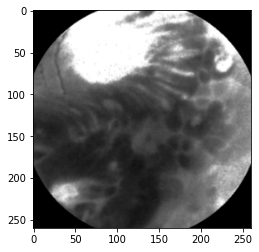

In [ ]:
plt.imshow(data[0][0][0], cmap='gray')

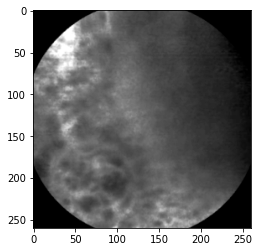

In [ ]:
plt.imshow(data[0][1][0], cmap='gray')

## Normalizacion de imagenes del dataset (Paso previo)

Este proceso lo hice antes de correr todo, para poder obtener la media y la desviacion estandar del dataset.


In [ ]:
"""
mean = 0.0
for images, _ in dataloaders['train']:
    batch_samples = images.size(0) 
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
mean = mean / len(dataloaders['train'].dataset)

var = 0.0
for images, _ in dataloaders['train']:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    var += ((images - mean.unsqueeze(1))**2).sum([0,2])
std = torch.sqrt(var / (len(dataloaders['train'].dataset)*260*260))

mean, std

# (tensor([0.3451]), tensor([0.1683]))
"""

"\nmean = 0.0\nfor images, _ in dataloaders['train']:\n    batch_samples = images.size(0) \n    images = images.view(batch_samples, images.size(1), -1)\n    mean += images.mean(2).sum(0)\nmean = mean / len(dataloaders['train'].dataset)\n\nvar = 0.0\nfor images, _ in dataloaders['train']:\n    batch_samples = images.size(0)\n    images = images.view(batch_samples, images.size(1), -1)\n    var += ((images - mean.unsqueeze(1))**2).sum([0,2])\nstd = torch.sqrt(var / (len(dataloaders['train'].dataset)*260*260))\n\nmean, std\n\n# (tensor([0.3451]), tensor([0.1683]))\n"

## 2. Inicializar la Red (Perceptron simple)

La función de activación del perceptrón será la transformación lineal de los pesos.

$$ y = xW^T + b $$

En algunos casos cuando se trabaja clasificación binaria se utiliza adicionalmente una función Sigmoidal para implementar la clasificación dentro de la red, de tal forma que el output de la misma se encuentre acotado entre 0 y 1. 

Este paso no es estrictamente necesario y de hecho hay algunas ventajas computacionales de no hacerlo así y con un poco de ayuda de la función de pérdida. 


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Perceptron(nn.Module):
    def __init__(self):
        super(Perceptron,self).__init__()
        self.linear = nn.Linear(260*260, 1)

    def forward(self,x):
        # Imagen aplanada en 1D
        x = x.view(-1,260*260)

        #Devolver directamente la salida de la capa linear
        y_pred = self.linear(x)

        #vs. ojo:
        #y_pred = self.sigmoid(y_pred)
        return y_pred

model = Perceptron()
print(model)

Perceptron(
  (linear): Linear(in_features=67600, out_features=1, bias=True)
)


## 3. Funcion de pérdida o costo

La función de pérdida debe corresponder a dos cosas:

1.   El tipo de problema que estamos resolviendo (clasificación o regresión)
2.   El tipo de output de la última capa de nuestra red.

BCEWithLogitsLoss permite recibir input en -inf, inf. Internamente aplica la función sigmoidal con la ventaja adicional que permite establecer pesos a las clases.

https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html

Desde el punto de vista computacional BCEWithLogitsLoss ofrece mejor protección contra el problema de underflow o vanishing gradient (no es la única forma de cuidarse de este fenómeno, hay que decirlo también)

https://discuss.pytorch.org/t/targets-between-0-and-1-in-torch-nn-bceloss/105819/2


In [ ]:
# Funcion de perdida (usamos BCELoss para clasificador binario si viene la Sigmoid, BCELogit en caso de ser otro tipo de salida )

# CrossEntropy si el clasificador es multiclase.
# criterion = nn.BCELoss() 
criterion = nn.BCEWithLogitsLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.SGD(model.parameters(),lr = 0.1)

## 4. Training loop

In [ ]:
n_epochs = 10
valid_loss_min = np.Inf  # set initial "min" to infinity

for epoch in range(n_epochs):
    # monitor losses
    train_loss = 0
    valid_loss = 0
    
    ## Loop de entrenamiento
    model.train() 
    for data, label in dataloaders['train']:
        # borrar gradientes
        optimizer.zero_grad()
        # forward pass: calcular predicciones pasando los datos del batch al modelo
        output = model(data) 
        # calcular la perdida mediante la funcion seleccionada
        # ojo, requerimos el unsquezze 
        target = label.unsqueeze(1).float()
        loss = criterion(output, target)

        # backward pass: calcular el gradiente de la perdida respecto de los parametros
        loss.backward()
        
        # actualizar los parametros (ejecutar un paso de optimizacion)
        optimizer.step()
        
        # actualizar nuestra perdida de la epoca
        train_loss += loss.item() * data.size(0)
        
    ## Evaluacion / Validacion
    model.eval()  
    for data,label in dataloaders['val']:
        # forward pass
        output = model(data)
        target = label.unsqueeze(1).float()
        loss = criterion(output,target)
        valid_loss = loss.item() * data.size(0)
    
    # Calcular la perdida promedio por epoca
    train_loss = train_loss / len(dataloaders['train'].sampler)
    valid_loss = valid_loss / len(dataloaders['val'].sampler)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # Guardar modelo si la perdida de validacion disminuye
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'slp_model_260x.pt')
        valid_loss_min = valid_loss


Epoch: 1 	Training Loss: 101.584294 	Validation Loss: 0.185964
Validation loss decreased (inf --> 0.185964).  Saving model ...
Epoch: 2 	Training Loss: 84.861806 	Validation Loss: 0.000000
Validation loss decreased (0.185964 --> 0.000000).  Saving model ...
Epoch: 3 	Training Loss: 71.830731 	Validation Loss: 0.645769
Epoch: 4 	Training Loss: 54.191871 	Validation Loss: 0.000000
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Epoch: 5 	Training Loss: 45.003251 	Validation Loss: 0.000000
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Epoch: 6 	Training Loss: 41.214523 	Validation Loss: 0.435169
Epoch: 7 	Training Loss: 37.414631 	Validation Loss: 0.481856
Epoch: 8 	Training Loss: 34.617728 	Validation Loss: 0.000000
Validation loss decreased (0.000000 --> 0.000000).  Saving model ...
Epoch: 9 	Training Loss: 32.260184 	Validation Loss: 0.198003
Epoch: 10 	Training Loss: 23.780276 	Validation Loss: 0.000000
Validation loss decreased (0.000000 --

In [ ]:
! cp "/content/slp_model_260x.pt" "/content/drive/MyDrive/CarpetaImagenes/models/slp_model_260x.pt"

## 5. Evaluacion final de modelo en Test Set


In [ ]:
# Cargar el modelo con la menor validation loss
model.load_state_dict(torch.load('slp_model_260x.pt'))

# model.load_state_dict(torch.load('mlp_model.pt'))
classes = list(range(0,10))

# Inicializacion
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval() 

for data, target in dataloaders['test']:
    # calcular predicciones (valor continuo)
    output = model(data)

    # calcular la perdida del batch
    loss = criterion(output, target.unsqueeze(1).float())

    # actualizar perdida total
    test_loss += loss.item()*data.size(0)

    # Convertir valores a prediccion
    pred = torch.round(torch.sigmoid(output))

    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))

    # Accuracy por clase
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# Estadisticas
test_loss = test_loss/len(dataloaders['test'].sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))


Test Loss: 37.965894

Test Accuracy of     0: 53% (148/278)
Test Accuracy of     1: 94% (690/734)


In [ ]:
! cp "/content/slp_model_260x.pt" "/content/drive/MyDrive/CarpetaImagenes/models/slp_model_260x.pt"

In [ ]:
(148 + 690) / (278 + 734)

0.8280632411067194

In [ ]:
pos_weight = 278 / 734
pos_weight

0.3787465940054496

## Bonus trivia

¿Por qué el Perceptron de SkLearn da mejores resultados que este?

Tip:

https://github.com/scikit-learn/scikit-learn/blob/e4ef854d031854932b7165d55bfd04a400af6b85/sklearn/linear_model/_stochastic_gradient.py#L509




## Referencias

Preparacion de dataset

https://colab.research.google.com/drive/1k8D9WilBf4NdTIEeZ0ye3E9AS91bsI3H#scrollTo=owx00y4Rx_kj

Referencias

Dataset y dataloader

https://towardsdatascience.com/building-efficient-custom-datasets-in-pytorch-2563b946fd9f

Modelo simple

https://towardsdatascience.com/multilayer-perceptron-for-image-classification-5c1f25738935

